# Introduction: This analyses calls variants on the single-cell ATAC data at known donor CHIP mutation regions.
 
### Steps:
1. Create bed file for the known CHIP variants from excel file. 
    Convert to hg38 (https://genome.ucsc.edu/cgi-bin/hgLiftOver)
    Add +/- 1kb
2. Run cellsnp for pileup near those regions
3. See if any fragments locations overlap the bed file (they should be if there is pileup)
4. Plot cells-by-CHIP mutants AF . Plot bulk for each mutant AF.
5. Using the de-multiplexed cells, how many of the known called variants are found in one donor. Also do the same as 

## Convert txt to bed

In [1]:
config_f = "config.yaml"
outdir=""
minCOUNT = 0.1
minAF = 0


frag_indir = "/home/isaac/lewis/mito_lineage/output/mtscATAC/data/CHIP_dec172021_b1/MTBlacklist_A2/"
samples = "Control,Flt3l,Input"
variants_f = "/data/Mito_Trace/data/processed/gilead_chip_profile/20210726_Croker_CD34_sample_ship_MW_20210726_Variants.csv"

In [2]:
samples = samples.split(",")


In [3]:
%matplotlib inline
from src.utils.parse_config import read_config_file
from src.utils.data_io import wrap_load_mtx_df

from src.config import ROOT_DIR
from os.path import join, dirname, exists
import os
import pandas as pd
from glob import glob
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import mplh.cluster_help as ch
%load_ext autoreload
%autoreload 2


fig_utils from mplh
here


In [4]:
config = read_config_file(config_f)
samples_dict = {ind+1: val for ind, val in enumerate(config["samples"])}
config


{'global': 'PROJECT',
 'variants_f': 'data/processed/gilead_chip_profile/20210222_Croker_CD34_sample_ship_MW.txt',
 'indir': '/data2/isshamie/mito_lineage/data/processed/mtscATAC/CHIP_april08_2021_Croker/MTblacklist',
 'experiment': 'CHIP_april08_2021',
 'genome': 'MTblacklist',
 'ref_fa': '/data2/mito_lineage/data/external/GRCh38_MT_blacklist/fasta/genome.fa',
 'samples': ['Control', 'Flt3l', 'Input']}

### Output

In [5]:
if outdir == "":
    outdir="./output"

if not os.path.exists(outdir):
    os.mkdir(outdir)
    
out_bed = join(outdir, "variants.hg38.1kb.bed")
out_hg38_bed = join(outdir, "variants.hg38.bed") # created from UCSC liftover online
out_hg19_bed = join(outdir, "variants.hg19.bed")

out_pileup_d = join(outdir,"variants_pileup")


REGION_VCF = join(outdir, "variants.hg38.vcf")
REGION_VCF_1base = join(outdir, "variants.hg38.1base.vcf")

# for exp in samples_dict.values():
#     if not exists(join(out_pileup_d, exp)):
#         os.mkdir(join(out_pileup_d, exp))
if not exists(join(out_pileup_d)):
    os.mkdir(join(out_pileup_d))



# 2. Create bed file for CHIP variants

In [6]:
# bed_df = pd.read_csv(variants_f, sep=',', header=None)
# bed_df[1]-=1
# bed_df[[0,1,2]].to_csv(out_hg19_bed, sep='\t', header=None, index=False)
# meta_df = bed_df.drop([0,1,2], axis=1).copy().rename({3:"REF", 4:"ALT"}, axis=1)

# bed_df

In [7]:
bed_df = pd.read_csv(variants_f, sep=',')
bed_df["Start"]-=1
bed_df[["HG19_Chr","Start","End"]].to_csv(out_hg19_bed, sep='\t', header=None, index=False)
meta_df = bed_df.drop(["HG19_Chr","Start","End"], axis=1).copy().rename({3:"REF", 4:"ALT"}, axis=1)

bed_df

,HG19_Chr,Start,End,Ref,Alt,Func.refGene,Gene.refGene,ExonicFunc.refGene,AAChange.refGene,Mutant reads,Total reads,VAF,Canopy ID,Donor ID
0,chr3,128204959,128204960,G,C,exonic,GATA2,nonsynonymous SNV,"GATA2:NM_001145662:exon3:c.C481G:p.P161A,GATA2...",1454,3225,0.450853,S02,RB1046
1,chr10,112356326,112356327,C,T,intronic,SMC3,NaN,NaN,644,6768,0.095154,S02,RB1046
2,chr7,148513984,148513985,T,G,intronic,EZH2,NaN,NaN,30,29419,0.001020,S06,RB1085
3,chrX,133527735,133527736,T,C,intronic,PHF6,NaN,NaN,55,12838,0.004284,S06,RB1085
4,chrX,44938688,44938689,A,C,intronic,KDM6A,NaN,NaN,99,5205,0.019020,S06,RB1085
5,chr3,38182362,38182363,A,C,intronic,MYD88,NaN,NaN,568,4816,0.117940,S06,RB1085
6,chr21,36206720,36206721,T,G,exonic,RUNX1,nonsynonymous SNV,"RUNX1:NM_001001890:exon4:c.A710C:p.Q237P,RUNX1...",24,1927,0.012455,S06,RB1085
7,chr7,50358708,50358709,T,G,intronic,IKZF1,NaN,NaN,110,26256,0.004190,S07,RB1071
8,chrX,39932034,39932035,A,C,exonic,BCOR,nonsynonymous SNV,"BCOR:NM_001123383:exon4:c.T2564G:p.L855R,BCOR:...",2122,15475,0.137124,S07,RB1071
9,chr8,117875464,117875465,A,C,exonic,RAD21,nonsynonymous SNV,RAD21:NM_006265:exon3:c.T178G:p.L60V,201,38924,0.005164,S08,RB1060


In [8]:
meta_df

,Ref,Alt,Func.refGene,Gene.refGene,ExonicFunc.refGene,AAChange.refGene,Mutant reads,Total reads,VAF,Canopy ID,Donor ID
0,G,C,exonic,GATA2,nonsynonymous SNV,"GATA2:NM_001145662:exon3:c.C481G:p.P161A,GATA2...",1454,3225,0.450853,S02,RB1046
1,C,T,intronic,SMC3,NaN,NaN,644,6768,0.095154,S02,RB1046
2,T,G,intronic,EZH2,NaN,NaN,30,29419,0.001020,S06,RB1085
3,T,C,intronic,PHF6,NaN,NaN,55,12838,0.004284,S06,RB1085
4,A,C,intronic,KDM6A,NaN,NaN,99,5205,0.019020,S06,RB1085
5,A,C,intronic,MYD88,NaN,NaN,568,4816,0.117940,S06,RB1085
6,T,G,exonic,RUNX1,nonsynonymous SNV,"RUNX1:NM_001001890:exon4:c.A710C:p.Q237P,RUNX1...",24,1927,0.012455,S06,RB1085
7,T,G,intronic,IKZF1,NaN,NaN,110,26256,0.004190,S07,RB1071
8,A,C,exonic,BCOR,nonsynonymous SNV,"BCOR:NM_001123383:exon4:c.T2564G:p.L855R,BCOR:...",2122,15475,0.137124,S07,RB1071
9,A,C,exonic,RAD21,nonsynonymous SNV,RAD21:NM_006265:exon3:c.T178G:p.L60V,201,38924,0.005164,S08,RB1060


## (outside notebook) Convert to hg38 using ucsc liftover save to outdir as variants.hg38.bed

In [9]:
vcf = pd.concat((bed_df, meta_df), axis=1).rename({"HG19_Chr":"#CHROM", "Start":"POS",
                                                  "Ref":"REF", "Alt":"ALT"}, axis=1)
vcf["ID"] = "."
vcf["QUAL"] = "."
vcf["FILTER"] = "PASS"
vcf["INFO"] = ""
#vcf[["#CHROM", "POS", "ID", "REF", "ALT", "QUAL", "FILTER", "INFO"]].to_csv(REGION_VCF, sep='\t', index=False)


vcf[["#CHROM", "POS", "ID", "REF", "ALT"]].to_csv(REGION_VCF, sep='\t', index=False)


vcf[["#CHROM", "POS", "ID", "REF", "ALT", "QUAL", "FILTER", "INFO"]]

,#CHROM,POS,ID,REF,REF,ALT,ALT,QUAL,FILTER,INFO
0,chr3,128204959,.,G,G,C,C,.,PASS,
1,chr10,112356326,.,C,C,T,T,.,PASS,
2,chr7,148513984,.,T,T,G,G,.,PASS,
3,chrX,133527735,.,T,T,C,C,.,PASS,
4,chrX,44938688,.,A,A,C,C,.,PASS,
5,chr3,38182362,.,A,A,C,C,.,PASS,
6,chr21,36206720,.,T,T,G,G,.,PASS,
7,chr7,50358708,.,T,T,G,G,.,PASS,
8,chrX,39932034,.,A,A,C,C,.,PASS,
9,chr8,117875464,.,A,A,C,C,.,PASS,


### Convert bed to (dummy)-vcf  for cellsnp-lite input

In [10]:
# Open a file in write mode to add the comment
# Then close the file and reopen it with pandas in append mode
with open(REGION_VCF, 'w') as f:
    f.write(f'##fileformat=VCFv4.2\n##reference=file://{config["ref_fa"]}\n')
vcf[["#CHROM", "POS", "ID", "REF", "ALT"]].to_csv(REGION_VCF, sep='\t', index=False, mode='a')


## +/- 500bps

In [11]:
bed_df["Start"]-=500
bed_df["End"]+=500
bed_df.to_csv(out_bed, sep='\t', header=None, index=False)

# 2. Run cellsnp
(since bam is separate for each experiment, need to run as that)

### Run with exclFLAG

Control
cellsnp-lite -s /data2/isshamie/mito_lineage/data/processed/mtscATAC/CHIP_april08_2021_Croker/MTblacklist/Control/outs/possorted_bam.bam -b /data2/isshamie/mito_lineage/data/processed/mtscATAC/CHIP_april08_2021_Croker/MTblacklist/Control/outs/filtered_peak_bc_matrix/barcodes.tsv -O ./output/variants_pileup/Control_1base -R ./output/variants.hg38.vcf --exclFLAG 772  -p 20 --minMAF 0 --minCOUNT 0.1 --UMItag None --cellTAG CB 


sh: 1: cellsnp-lite: not found
ic| prefix: 'cellSNP.tag'


4
Variant
0     0
1     0
2     0
3     0
4     1
5     0
6     0
7     0
8     0
9     0
10    0
11    1
12    0
13    0
14    0
15    0
16    0
17    0
18    1
19    0
20    1
21    0
22    0
23    0
24    0
25    0
26    0
dtype: int64


sh: 1: cellsnp-lite: not found
ic| prefix: 'cellSNP.tag'


Flt3l
cellsnp-lite -s /data2/isshamie/mito_lineage/data/processed/mtscATAC/CHIP_april08_2021_Croker/MTblacklist/Flt3l/outs/possorted_bam.bam -b /data2/isshamie/mito_lineage/data/processed/mtscATAC/CHIP_april08_2021_Croker/MTblacklist/Flt3l/outs/filtered_peak_bc_matrix/barcodes.tsv -O ./output/variants_pileup/Flt3l_1base -R ./output/variants.hg38.vcf --exclFLAG 772  -p 20 --minMAF 0 --minCOUNT 0.1 --UMItag None --cellTAG CB 
9
Variant
0     0
1     0
2     0
3     0
4     2
5     0
6     0
7     0
8     0
9     0
10    0
11    1
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    3
20    2
21    0
22    0
23    1
24    0
25    0
26    0
dtype: int64


sh: 1: cellsnp-lite: not found
ic| prefix: 'cellSNP.tag'


Input
cellsnp-lite -s /data2/isshamie/mito_lineage/data/processed/mtscATAC/CHIP_april08_2021_Croker/MTblacklist/Input/outs/possorted_bam.bam -b /data2/isshamie/mito_lineage/data/processed/mtscATAC/CHIP_april08_2021_Croker/MTblacklist/Input/outs/filtered_peak_bc_matrix/barcodes.tsv -O ./output/variants_pileup/Input_1base -R ./output/variants.hg38.vcf --exclFLAG 772  -p 20 --minMAF 0 --minCOUNT 0.1 --UMItag None --cellTAG CB 
4
Variant
0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    2
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    2
20    0
21    0
22    0
23    0
24    0
25    0
26    0
dtype: int64


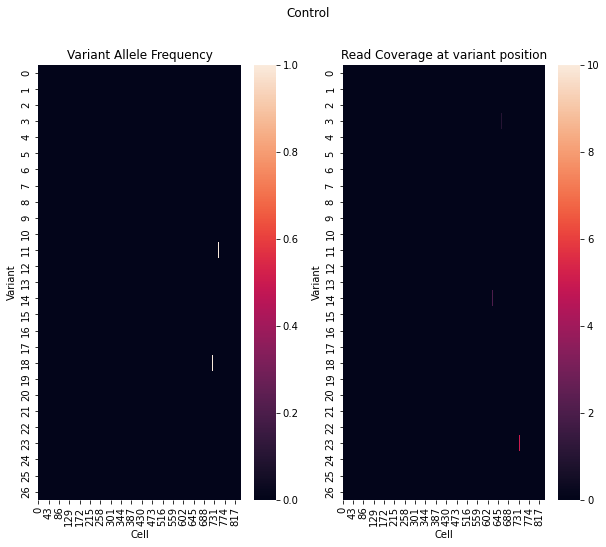

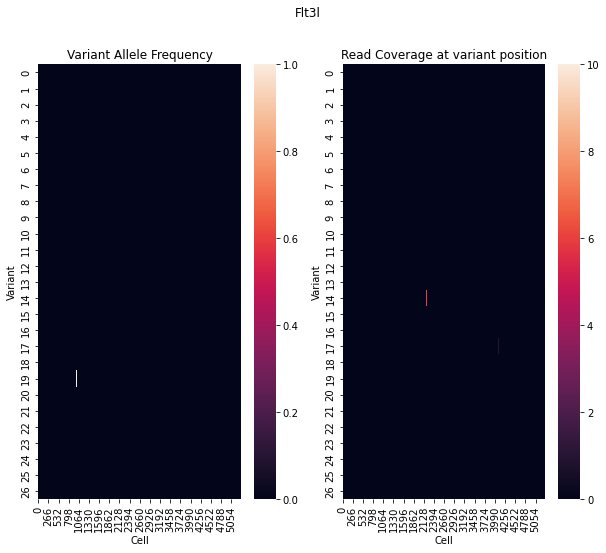

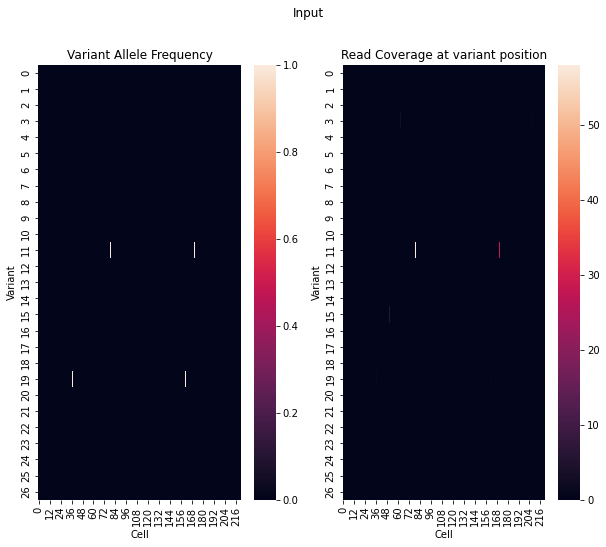

In [12]:
%matplotlib inline
for exp in samples_dict.values():
    print(exp)
    BAM = join(config["indir"], exp, "outs/possorted_bam.bam")
    BARCODE = join(config["indir"], exp, "outs/filtered_peak_bc_matrix/barcodes.tsv")
    OUT_DIR = join(out_pileup_d, exp+"_1base")
    cmd = f"cellsnp-lite -s {BAM} -b {BARCODE} -O {OUT_DIR} -R {REGION_VCF} --exclFLAG 772  -p 20 --minMAF {minAF} --minCOUNT {minCOUNT} --UMItag None --cellTAG CB "
    #shell: "cellsnp-lite -s {input.bam_f} --exclFLAG {params.exclFLAG}  -b {input.barcode_f} -O {output} -p 20 --minMAF {params.minMAF} --minCOUNT {params.minCOUNT} --gzip --chrom chrM --printSkipSNPs --UMItag None --cellTAG CB 2> {log}"#chrM"
    print(cmd)
    os.system(cmd)
    
    AD, DP = wrap_load_mtx_df(OUT_DIR, oth_f=False, prefix="cellSNP.tag",
                         columns=('Variant', 'Cell', 'integer'), inc_af=False,
                         as_dense=True, var_names=False, vcf_prefix="cellSNP.base")

    AF=AD/DP.fillna(0)
    AF
    print((AD>0).sum().sum())
    print((AF>0).sum(axis=1))
    f, ax = plt.subplots(ncols=2, figsize=(10,8))
    sns.heatmap(AF.fillna(0), ax=ax[0], vmin=0)
    ax[0].set_title("Variant Allele Frequency")
    sns.heatmap(DP, ax=ax[1], vmin=0)
    ax[1].set_title("Read Coverage at variant position")
    f.suptitle(exp)
    plt.savefig(join(outdir,f"chip_vaf_{exp}.png"))

## Run 1base just in case

sh: 1: cellsnp-lite: not found
ic| prefix: 'cellSNP.tag'


Control
cellsnp-lite -s /data2/isshamie/mito_lineage/data/processed/mtscATAC/CHIP_april08_2021_Croker/MTblacklist/Control/outs/possorted_bam.bam -b /data2/isshamie/mito_lineage/data/processed/mtscATAC/CHIP_april08_2021_Croker/MTblacklist/Control/outs/filtered_peak_bc_matrix/barcodes.tsv -O ./output/variants_pileup/Control -R ./output/variants.hg38.1base.vcf --exclFLAG 772  -p 20 --minMAF 0 --minCOUNT 0.1 --UMItag None --cellTAG CB 
0
Variant
0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
dtype: int64
Variant
0     0
1     0
2     0
3     2
4     1
5     0
6     0
7     0
8     0
9     0
10    0
11    1
12    0
13    0
14    1
15    1
16    0
17    0
18    1
19    0
20    1
21    0
22    0
23    1
24    0
25    1
26    0
dtype: int64


sh: 1: cellsnp-lite: not found
ic| prefix: 'cellSNP.tag'


Flt3l
cellsnp-lite -s /data2/isshamie/mito_lineage/data/processed/mtscATAC/CHIP_april08_2021_Croker/MTblacklist/Flt3l/outs/possorted_bam.bam -b /data2/isshamie/mito_lineage/data/processed/mtscATAC/CHIP_april08_2021_Croker/MTblacklist/Flt3l/outs/filtered_peak_bc_matrix/barcodes.tsv -O ./output/variants_pileup/Flt3l -R ./output/variants.hg38.1base.vcf --exclFLAG 772  -p 20 --minMAF 0 --minCOUNT 0.1 --UMItag None --cellTAG CB 
1
Variant
0     0
1     0
2     0
3     0
4     1
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
dtype: int64
Variant
0     0
1     4
2     0
3     2
4     2
5     0
6     1
7     1
8     0
9     2
10    0
11    1
12    0
13    1
14    3
15    2
16    0
17    1
18    0
19    3
20    2
21    0
22    0
23    4
24    1
25    3
26    0
dtype: int64


sh: 1: cellsnp-lite: not found
ic| prefix: 'cellSNP.tag'


Input
cellsnp-lite -s /data2/isshamie/mito_lineage/data/processed/mtscATAC/CHIP_april08_2021_Croker/MTblacklist/Input/outs/possorted_bam.bam -b /data2/isshamie/mito_lineage/data/processed/mtscATAC/CHIP_april08_2021_Croker/MTblacklist/Input/outs/filtered_peak_bc_matrix/barcodes.tsv -O ./output/variants_pileup/Input -R ./output/variants.hg38.1base.vcf --exclFLAG 772  -p 20 --minMAF 0 --minCOUNT 0.1 --UMItag None --cellTAG CB 
0
Variant
0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
dtype: int64
Variant
0     0
1     0
2     0
3     2
4     0
5     0
6     0
7     0
8     1
9     0
10    0
11    2
12    0
13    0
14    0
15    1
16    1
17    0
18    0
19    2
20    0
21    0
22    0
23    0
24    0
25    0
26    1
dtype: int64


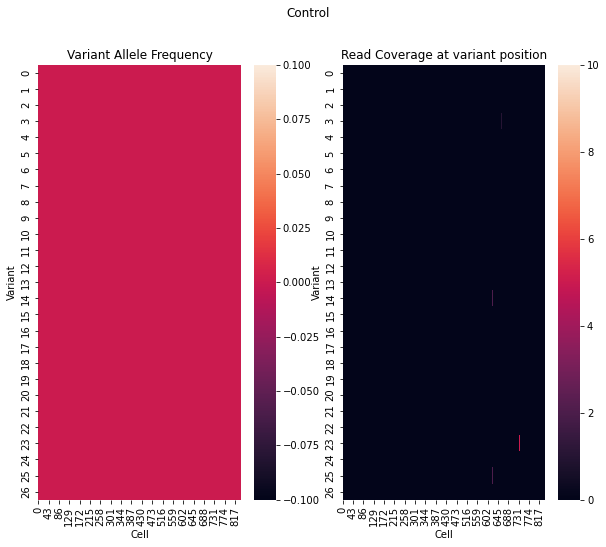

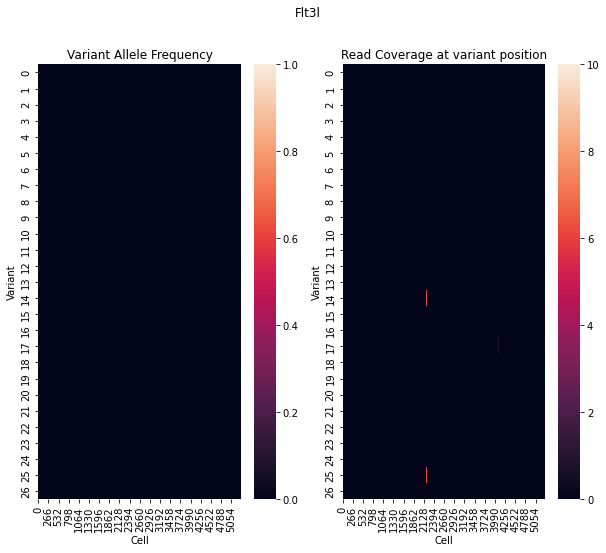

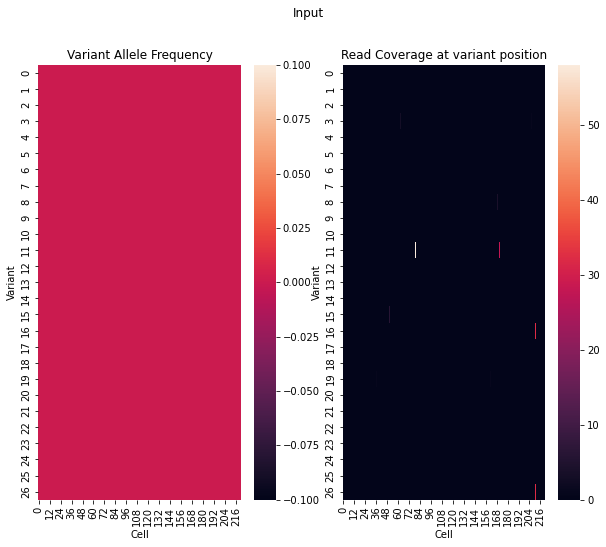

In [13]:
%matplotlib inline
def copy_df(df):
    return df.copy()
def pos_add(df):
    df['POS']+= 1
    return df
def vcf_save(df, fname, config):
    # Then close the file and reopen it with pandas in append mode
    with open(fname, 'w') as f:
        f.write(f'##fileformat=VCFv4.2\n##reference=file://{config["ref_fa"]}\n')
    df[["#CHROM", "POS", "ID", "REF", "ALT"]].to_csv(fname, sep='\t', index=False, mode='a')
    return

vcf_save(vcf.pipe(copy_df).pipe(pos_add),REGION_VCF_1base, config)

for exp in samples_dict.values():
    print(exp)
    BAM = join(config["indir"], exp, "outs/possorted_bam.bam")
    BARCODE = join(config["indir"], exp, "outs/filtered_peak_bc_matrix/barcodes.tsv")
    OUT_DIR = join(out_pileup_d, exp)
    cmd = f"cellsnp-lite -s {BAM} -b {BARCODE} -O {OUT_DIR} -R {REGION_VCF_1base} --exclFLAG 772  -p 20 --minMAF {minAF} --minCOUNT {minCOUNT} --UMItag None --cellTAG CB "
    #shell: "cellsnp-lite -s {input.bam_f} --exclFLAG {params.exclFLAG}  -b {input.barcode_f} -O {output} -p 20 --minMAF {params.minMAF} --minCOUNT {params.minCOUNT} --gzip --chrom chrM --printSkipSNPs --UMItag None --cellTAG CB 2> {log}"#chrM"
    print(cmd)
    os.system(cmd)
    AD, DP = wrap_load_mtx_df(OUT_DIR, oth_f=False, prefix="cellSNP.tag",
                         columns=('Variant', 'Cell', 'integer'), inc_af=False,
                         as_dense=True, var_names=False, vcf_prefix="cellSNP.base")

    AF=AD/DP.fillna(0)
    
    print((AD>0).sum().sum())
    print((AF>0).sum(axis=1))
    print((DP>0).sum(axis=1))
    f, ax = plt.subplots(ncols=2, figsize=(10,8))
    sns.heatmap(AF.fillna(0), ax=ax[0], vmin=0)
    ax[0].set_title("Variant Allele Frequency")
    sns.heatmap(DP, ax=ax[1], vmin=0)
    ax[1].set_title("Read Coverage at variant position")
    f.suptitle(exp)
    plt.savefig(join(outdir,f"chip_vaf_{exp}_off1bp.png"))

## Run w/out exclflag

sh: 1: cellsnp-lite: not found
ic| prefix: 'cellSNP.tag'


Control
cellsnp-lite -s /data2/isshamie/mito_lineage/data/processed/mtscATAC/CHIP_april08_2021_Croker/MTblacklist/Control/outs/possorted_bam.bam -b /data2/isshamie/mito_lineage/data/processed/mtscATAC/CHIP_april08_2021_Croker/MTblacklist/Control/outs/filtered_peak_bc_matrix/barcodes.tsv -O ./output/variants_pileup/Control_noEXCL -R ./output/variants.hg38.vcf  -p 20 --minMAF 0 --minCOUNT 0.1 --UMItag None --cellTAG CB 
4
Variant
0     0
1     0
2     0
3     0
4     1
5     0
6     0
7     0
8     0
9     0
10    0
11    1
12    0
13    0
14    0
15    0
16    0
17    0
18    1
19    0
20    1
21    0
22    0
23    0
24    0
25    0
26    0
dtype: int64


sh: 1: cellsnp-lite: not found
ic| prefix: 'cellSNP.tag'


Flt3l
cellsnp-lite -s /data2/isshamie/mito_lineage/data/processed/mtscATAC/CHIP_april08_2021_Croker/MTblacklist/Flt3l/outs/possorted_bam.bam -b /data2/isshamie/mito_lineage/data/processed/mtscATAC/CHIP_april08_2021_Croker/MTblacklist/Flt3l/outs/filtered_peak_bc_matrix/barcodes.tsv -O ./output/variants_pileup/Flt3l_noEXCL -R ./output/variants.hg38.vcf  -p 20 --minMAF 0 --minCOUNT 0.1 --UMItag None --cellTAG CB 
7
Variant
0     0
1     0
2     0
3     0
4     2
5     0
6     0
7     0
8     0
9     0
10    0
11    1
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    3
20    1
21    0
22    0
23    0
24    0
25    0
26    0
dtype: int64


sh: 1: cellsnp-lite: not found
ic| prefix: 'cellSNP.tag'


Input
cellsnp-lite -s /data2/isshamie/mito_lineage/data/processed/mtscATAC/CHIP_april08_2021_Croker/MTblacklist/Input/outs/possorted_bam.bam -b /data2/isshamie/mito_lineage/data/processed/mtscATAC/CHIP_april08_2021_Croker/MTblacklist/Input/outs/filtered_peak_bc_matrix/barcodes.tsv -O ./output/variants_pileup/Input_noEXCL -R ./output/variants.hg38.vcf  -p 20 --minMAF 0 --minCOUNT 0.1 --UMItag None --cellTAG CB 
3
Variant
0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    2
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    1
20    0
21    0
22    0
23    0
24    0
25    0
26    0
dtype: int64


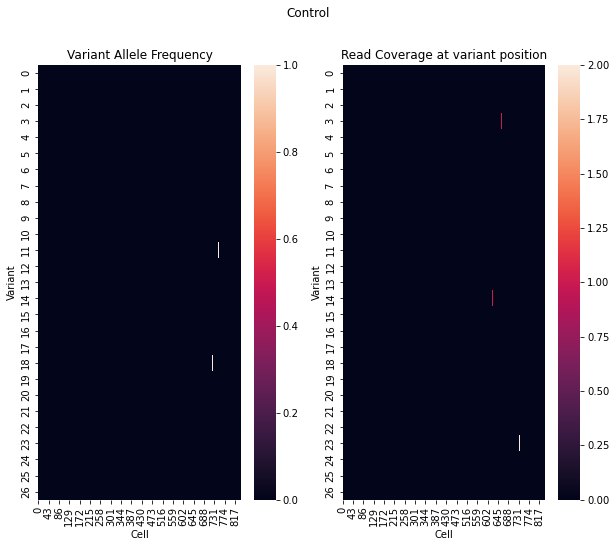

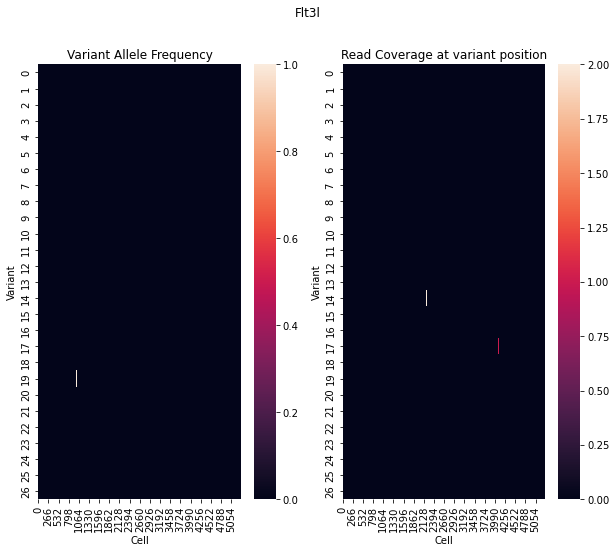

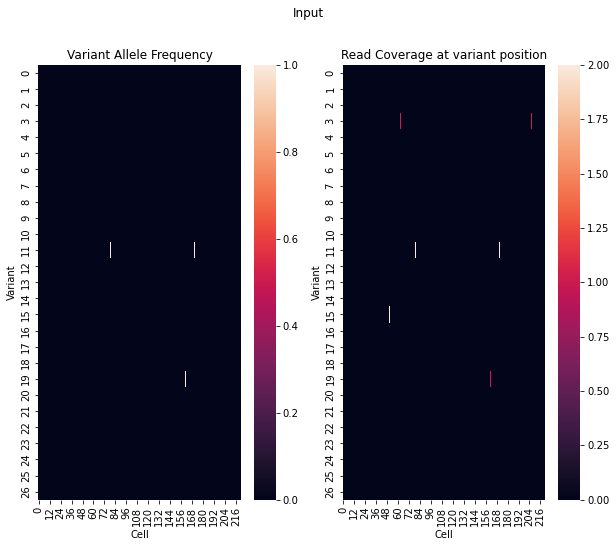

In [14]:
%matplotlib inline
for exp in samples_dict.values():
    print(exp)
    BAM = join(config["indir"], exp, "outs/possorted_bam.bam")
    BARCODE = join(config["indir"], exp, "outs/filtered_peak_bc_matrix/barcodes.tsv")
    OUT_DIR = join(out_pileup_d, exp+"_noEXCL")
    cmd = f"cellsnp-lite -s {BAM} -b {BARCODE} -O {OUT_DIR} -R {REGION_VCF}  -p 20 --minMAF {minAF} --minCOUNT {minCOUNT} --UMItag None --cellTAG CB "
    print(cmd)
    os.system(cmd)

    AD, DP = wrap_load_mtx_df(OUT_DIR, oth_f=False, prefix="cellSNP.tag",
                         columns=('Variant', 'Cell', 'integer'), inc_af=False,
                         as_dense=True, var_names=False, vcf_prefix="cellSNP.base")

    AF=AD/DP.fillna(0)
    AF
    print((AD>0).sum().sum())
    print((AF>0).sum(axis=1))
    f, ax = plt.subplots(ncols=2, figsize=(10,8))
    sns.heatmap(AF.fillna(0), ax=ax[0], vmin=0)
    ax[0].set_title("Variant Allele Frequency")
    sns.heatmap(DP, ax=ax[1], vmin=0)
    ax[1].set_title("Read Coverage at variant position")
    f.suptitle(exp)